In [1]:
import torch
import numpy as np
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch import optim
import numpy as np

from syft.frameworks.torch.differential_privacy import pate

W0627 22:18:11.037980 139637880330048 secure_random.py:22] Falling back to insecure randomness since the required custom op could not be found for the installed version of TensorFlow (1.14.1-dev20190517). Fix this by compiling custom ops.
W0627 22:18:11.057770 139637880330048 deprecation_wrapper.py:119] From /home/ayush/anaconda3/lib/python3.7/site-packages/tf_encrypted/session.py:28: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,),(0.5,))])

trainset = datasets.MNIST('~/.pytorch/MNIST_data', train=True, download=True, transform=transform)
testset = datasets.MNIST('~/.pytorch/MNIST_data', train=False, download=True, transform=transform)

In [3]:
print(len(trainset))
print(len(testset))

60000
10000


In [4]:
num_teacher = 100
len_teacher_set = len(trainset)//num_teacher

teacher_set = [torch.utils.data.Subset(trainset, list(range(i * len_teacher_set, (i+1) * len_teacher_set))) for i in range(num_teacher)]
student_set = torch.utils.data.Subset(testset, list(range(int(len(testset) * 0.9))))
test_set = torch.utils.data.Subset(testset, list(range(int(len(testset) * 0.9), len(testset))))

print("Number of teachers : ", num_teacher)
print("Length of data in teacher set : ", len_teacher_set)
print("Length of student set : ", len(student_set))
print("Length of test set : ", len(test_set))

Number of teachers :  100
Length of data in teacher set :  600
Length of student set :  9000
Length of test set :  1000


In [5]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
    
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.log_softmax(self.fc2(x))
        
        return x

In [6]:
device = torch.device("cuda" if torch.cuda.is_available else "cpu")

teachers = [Model().to(device) for _ in range(num_teacher)]
student = Model().to(device)

In [7]:
teacherloader = [torch.utils.data.DataLoader(data, batch_size=60, shuffle = True, drop_last=True) for data in teacher_set]
teacheroptim = [optim.SGD(teacher.parameters(), lr = 0.01, momentum = 0.5) for teacher in teachers]
criterion = nn.NLLLoss()

In [8]:
for model in teachers:
    model.train()

In [40]:
epochs = 20

teacher_train_history = {'avg_losses':{}, 'avg_accuracies':{}}
for e in range(epochs):
    print("Epoch ", (e+1), " ...")
    
    avgloss = []
    avgacc = []
    
    for i in range(num_teacher):
        counter = 0
        total_loss = 0
        acc_count = 0
        
        model = teachers[i]
        dataloader = teacherloader[i]
        optimizer = teacheroptim[i]
        
        for images, labels in dataloader:
            counter += images.size(0)
            
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            logps = model(images)
            preds = torch.argmax(torch.exp(logps), dim=1)
            
            loss = criterion(logps, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item() * images.size(0)
            acc_count += (preds == labels).sum().item()
        
        avgloss.append(total_loss/counter)
        avgacc.append(acc_count/counter)
    
    print(" Average losses : ", [avgl for avgl in avgloss])
    print(" Average accuracies : ", [avga for avga in avgacc])
    teacher_train_history['avg_losses'][e] = avgloss
    teacher_train_history['avg_accuracies'][e] = avgacc 

Epoch  1  ...


/home/ayush/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


 Average losses :  [1.322069478034973, 1.3143831372261048, 1.3358590126037597, 0.8424167633056641, 1.5536722898483277, 1.0164905309677124, 1.0264011383056642, 0.9239776134490967, 1.241423201560974, 1.222818100452423, 0.9292359054088593, 1.5125106811523437, 1.4597261905670167, 1.1736698210239411, 1.1267350912094116, 1.1538914620876313, 0.893746143579483, 0.8001051783561707, 1.2837944865226745, 1.6354867815971375, 1.141276353597641, 1.4428208827972413, 0.9658965468406677, 1.4684861421585083, 1.4299031853675843, 1.2795259833335877, 1.2883686661720275, 1.0270620107650756, 1.4321748614311218, 1.1866868257522583, 1.0257380187511445, 1.313690996170044, 0.9787945806980133, 1.1459208607673645, 1.055632346868515, 1.1597641587257386, 0.9763472676277161, 1.1186741769313813, 1.033055740594864, 1.094309574365616, 1.15803262591362, 1.1965353786945343, 0.9649561882019043, 0.9936397969722748, 1.3716057896614076, 1.1645007848739624, 1.0563869416713714, 1.1811462044715881, 1.2468196034431458, 1.075628030

 Average losses :  [1.092940330505371, 1.1763811588287354, 1.141792392730713, 0.7419507205486298, 1.3371703505516053, 0.9473936676979064, 0.9023220777511597, 0.8399396240711212, 1.1204252779483794, 1.0664639949798584, 0.7535601794719696, 1.2734887599945068, 1.2906203746795655, 1.0389627277851106, 1.0022438168525696, 0.9450779497623444, 0.8274330615997314, 0.7865053236484527, 1.063464617729187, 1.4890063643455504, 1.0319369733333588, 1.2352302432060243, 0.8569286108016968, 1.3322657585144042, 1.256183910369873, 1.13791943192482, 1.1471998810768127, 0.8874094188213348, 1.2350436449050903, 1.0219104588031769, 0.8278429985046387, 1.0795138001441955, 0.8088868021965027, 1.0668084979057313, 1.0022950887680053, 0.991874498128891, 0.9374871850013733, 0.9793374955654144, 0.8906221508979797, 0.9799729704856872, 1.020965075492859, 1.1260664880275726, 0.8878746807575226, 0.9528464198112487, 1.1487053394317628, 1.0234926402568818, 0.9268856346607208, 1.040658062696457, 1.137269425392151, 0.91750378

 Average losses :  [0.9793831884860993, 1.142184841632843, 0.9882035374641418, 0.6474402159452438, 1.1711481273174287, 0.7839546203613281, 0.7892940759658813, 0.8227712512016296, 1.024291181564331, 0.9246510207653046, 0.7243837535381317, 1.1367091894149781, 1.096242755651474, 0.9408612668514251, 0.9438440799713135, 0.8912484526634217, 0.7515873610973358, 0.7169043004512787, 0.9071103453636169, 1.27978355884552, 0.9492314755916595, 1.1102507174015046, 0.7740409076213837, 1.1768619537353515, 1.1070041000843047, 0.9785092532634735, 1.0304137170314789, 0.7794912278652191, 1.061966472864151, 0.9820916652679443, 0.8394777834415436, 0.9888573944568634, 0.7592352151870727, 0.9598924160003662, 0.96474968791008, 0.8366727530956268, 0.8078681528568268, 0.8824816644191742, 0.7904573500156402, 0.8173076689243317, 0.8473960101604462, 0.9515589475631714, 0.805511724948883, 0.802232539653778, 1.0724129855632782, 0.8348469495773315, 0.7903572142124176, 0.9584307610988617, 0.9806267976760864, 0.88698430

 Average losses :  [0.8571651220321655, 1.0523953855037689, 0.9248990535736084, 0.6225798726081848, 1.0258102536201477, 0.7201495826244354, 0.7449503004550934, 0.6992268562316895, 0.884929996728897, 0.8545720279216766, 0.6419032067060471, 0.9809381127357483, 1.020287150144577, 0.8542145431041718, 0.8656980693340302, 0.7957561790943146, 0.6852227956056595, 0.6904178082942962, 0.809161514043808, 1.1417647898197174, 0.8761350631713867, 0.9973809659481049, 0.6911109447479248, 1.1169430255889892, 0.9858126282691956, 0.9260885417461395, 0.9711157739162445, 0.7292297899723053, 0.9631753265857697, 0.8100601315498352, 0.6992528557777404, 0.856085067987442, 0.7039544939994812, 0.8449144303798676, 0.9144187331199646, 0.7494633734226227, 0.7437266528606414, 0.8300933480262757, 0.7077744662761688, 0.7671936899423599, 0.8292212724685669, 0.905165696144104, 0.7734538972377777, 0.7571427524089813, 0.9294989824295044, 0.8150038480758667, 0.7576812922954559, 0.884346479177475, 0.8869199752807617, 0.7810

 Average losses :  [0.8665883779525757, 1.0242734789848327, 0.9023586630821228, 0.5718885689973832, 0.9189327359199524, 0.7077935814857483, 0.677304482460022, 0.6543901085853576, 0.8280853748321533, 0.7063680052757263, 0.5675014376640319, 0.9303406119346619, 0.9217710673809052, 0.7707672953605652, 0.82921462059021, 0.7340786635875702, 0.6428453475236893, 0.6145229011774063, 0.7240177452564239, 0.9840877413749695, 0.8362184286117553, 0.9234958052635193, 0.6764335930347443, 0.99150151014328, 0.9014185249805451, 0.7409095466136932, 0.8744855463504791, 0.674403440952301, 0.8158392906188965, 0.8836217045783996, 0.6647262841463089, 0.8302650630474091, 0.6147376537322998, 0.8458985388278961, 0.8352876424789428, 0.6851743698120117, 0.6342198580503464, 0.7294780135154724, 0.6446067690849304, 0.7307755589485169, 0.7405885815620422, 0.8436466097831726, 0.6405842244625092, 0.6726424723863602, 0.8843597650527955, 0.698286172747612, 0.669776850938797, 0.8102298498153686, 0.8071011781692505, 0.778544

 Average losses :  [0.7557266592979431, 0.8575419962406159, 0.7323870897293091, 0.5656463086605072, 0.826004022359848, 0.5918667048215867, 0.622597736120224, 0.6238398730754853, 0.754289573431015, 0.7249682068824768, 0.576419910788536, 0.8221361637115479, 0.8049379169940949, 0.7038000762462616, 0.780567592382431, 0.6887258589267731, 0.5862482279539108, 0.5757675766944885, 0.6870410352945328, 0.9069212019443512, 0.6947587728500366, 0.8740108966827392, 0.6066406518220901, 0.9370232880115509, 0.8748601675033569, 0.7503911435604096, 0.8510790705680847, 0.6214928925037384, 0.8328231871128082, 0.7590720951557159, 0.5863099932670593, 0.6945984363555908, 0.5764822900295258, 0.7711914837360382, 0.7702277779579163, 0.6005601733922958, 0.6287554234266282, 0.6595446825027466, 0.5770984798669815, 0.6731709539890289, 0.6886565506458282, 0.7684555172920227, 0.6131363481283187, 0.6057974249124527, 0.8052869081497193, 0.6781902372837066, 0.6469282925128936, 0.7337657272815704, 0.7736186861991883, 0.680

 Average losses :  [0.6369599014520645, 0.795462018251419, 0.7379427671432495, 0.4979185789823532, 0.777888023853302, 0.5766951233148575, 0.5901352256536484, 0.5917685210704804, 0.7467000305652618, 0.6714366853237153, 0.5204902172088623, 0.7563510000705719, 0.734607857465744, 0.6709985077381134, 0.7472395211458206, 0.6313295513391495, 0.5554653882980347, 0.5474140554666519, 0.6135704964399338, 0.8321036636829376, 0.6897182911634445, 0.8030703842639924, 0.5598342150449753, 0.8962924063205719, 0.7601687848567963, 0.7288146555423737, 0.7811241209506988, 0.621964493393898, 0.7102778494358063, 0.7244979500770569, 0.5683887481689454, 0.6697582244873047, 0.5042899340391159, 0.6388039231300354, 0.7060918211936951, 0.5655937224626542, 0.5501063615083694, 0.650749322772026, 0.5400246828794479, 0.629814425110817, 0.6509054899215698, 0.7658712863922119, 0.6348827391862869, 0.6699399471282959, 0.7493805885314941, 0.5998994141817093, 0.6569232821464539, 0.7356656134128571, 0.690181028842926, 0.63278

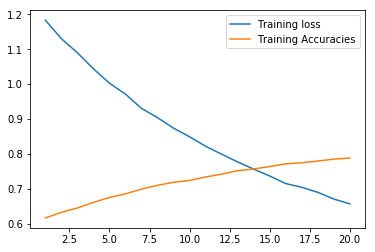

In [44]:
import matplotlib.pyplot as plt
plt.plot(range(1, epochs+1),[np.mean(teacher_train_history['avg_losses'][x]) for x in teacher_train_history['avg_losses']], label="Training loss")
plt.plot(range(1, epochs+1),[np.mean(teacher_train_history['avg_accuracies'][x]) for x in teacher_train_history['avg_accuracies']], label="Training Accuracies")
plt.legend()
plt.show()